# Tweets influencing Bitcoin

La idea es crear un modelo que dado un tweet pueda predecir su efecto en el precion del bitcoin. Las categorias son Positivo: aumenta el precio, Negativo: disminuye el precio, Neutral: no hay cambio en el precio.

Para esto usaremos un modelo de clasificacion.

In [109]:
!pip install langid
!pip install many-stop-words
!pip install emoji
import pandas as pd
import langid
import warnings
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statistics import mode
import nltk
from nltk.corpus import stopwords
import many_stop_words
import emoji
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import ssl
from joblib import dump, load
warnings.filterwarnings('ignore')


## Perfilamiento

In [3]:
filename = "mbsa.csv"
datosO = pd.read_csv(filename)

In [57]:
datos = datosO.sample(n=10000)

In [58]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 3583058 to 18027053
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       10000 non-null  object
 1   text       10000 non-null  object
 2   Sentiment  9536 non-null   object
dtypes: object(3)
memory usage: 312.5+ KB


### Eliminar nulos

In [59]:
datos = datos[datos['Sentiment'].notna()]

### Estadisticas del Tweet

In [60]:
datos['Conteo'] = [len(x) for x in datos['text']]
datos['Moda'] = [[mode([x for x in i.split(' ')])][0] for i in datos['text']]
datos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in datos['text']]
datos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in datos['text']]
datos.head()

,Date,text,Sentiment,Conteo,Moda,Max,Min
3583058,2018-08-03,@lifeoncoin,Negative,11,@lifeoncoin,11,11
8839737,2019-07-03,La ‘revolución’ del,Positive,19,La,12,2
558264,2019-05-24,This company PAYS DAILY and in BITCOIN!\n\nBes...,Positive,124,This,23,2
14811155,2019-09-11,One Bitcoin now worth $10068.713. Market Cap $...,Positive,94,One,11,2
2376931,2018-02-06,https://www.c-span.org/video/?440770-1/jay-cla...,Positive,125,https://www.c-span.org/video/?440770-1/jay-cla...,109,4


### Hashtags, menciones y vinculos

In [61]:
def tagsMensUrls(x):
    x = str(x)
    x = x.replace('\n',' ')
    x = x.replace('(',' ')
    x = x.replace(')',' ')
    x = x.replace('\'','')
    return x.count(' #'), x.count(' @'),x.count('http'), (tags:=bus(x,'#')), (ment:=bus(x,'@')), newText(x,tags,ment)
def bus(x,a):
    l = []
    for y in x.split(' '):
        if (y.startswith(a)):
            l.append(y[1:].lower())
    return l
def newText(x,tags,ment):
    x = x.lower()
    for t in tags:
        x = x.replace("#"+t,"")
    for m in ment:
        x = x.replace("@"+m,"")
    for u in bus(x,"http"):
        x = x.replace('h'+u,"")
    return x
        
tagsMensUrlsInfo = pd.DataFrame(datos["text"].apply(tagsMensUrls).tolist(),columns=["Ntags","Nmentions","Nurls","tags","mentions","newText"],index=datos.index)
datos = pd.concat([datos, tagsMensUrlsInfo], axis=1)
datos.head()

,Date,text,Sentiment,Conteo,Moda,Max,Min,Ntags,Nmentions,Nurls,tags,mentions,newText
3583058,2018-08-03,@lifeoncoin,Negative,11,@lifeoncoin,11,11,0,0,0,[],[lifeoncoin],
8839737,2019-07-03,La ‘revolución’ del,Positive,19,La,12,2,0,0,0,[],[],la ‘revolución’ del
558264,2019-05-24,This company PAYS DAILY and in BITCOIN!\n\nBes...,Positive,124,This,23,2,0,1,1,[],[youtube],this company pays daily and in bitcoin! best ...
14811155,2019-09-11,One Bitcoin now worth $10068.713. Market Cap $...,Positive,94,One,11,2,2,0,0,"[coindesk, bitcoin]",[],one bitcoin now worth $10068.713. market cap $...
2376931,2018-02-06,https://www.c-span.org/video/?440770-1/jay-cla...,Positive,125,https://www.c-span.org/video/?440770-1/jay-cla...,109,4,0,0,1,[],[],$alts $btc $eth


### Encontrar idiomas

In [62]:
# datos["lang"]=datos["newText"].apply(lambda x: langid.classify(x)[0])
# plt.style.use('dark_background')
# fig=plt.figure(figsize=(21,4))
# n,b,p=plt.hist(datos["lang"])
# plt.title("Idiomas")
# datos['lang'].value_counts()

### Usar solo 10 idiomas mas relevantes

In [63]:
# languages = datos['lang'].value_counts().index.values[:10]
# datos = datos.loc[datos['lang'].isin(languages)]

### Ajustar sentimiento

In [64]:
patternP = re.compile("^(\s|\t)*(p|P)(\s|[A-Za-z])*$")
patternN = re.compile("^(\s|\t)*(neg|Neg)(\s|[A-Za-z])*$")
patternNeu = re.compile("^(\s|\t)*(neu|Neu)(\s|[A-Za-z])*$")
patternNumb = re.compile("^(\s|\t|[A-Za-z])*([0-9])+(\s|\t|[A-Za-z])*$")
datos.loc[[True if patternP.fullmatch(datos['Sentiment'][x]) is not None else False for x in datos.index], 'Sentiment'] = "Positive"
datos.loc[[True if patternN.fullmatch(datos['Sentiment'][x]) is not None else False for x in datos.index], 'Sentiment'] = "Negative"
datos.loc[[True if patternNeu.fullmatch(datos['Sentiment'][x]) is not None else False for x in datos.index], 'Sentiment'] = "Neutral"
datos = datos.drop(datos[[True if patternNumb.fullmatch(datos['Sentiment'][x]) is not None else False for x in datos.index]].index)

### Visualizar datos

Text(0.5, 1.0, 'Sentiment')

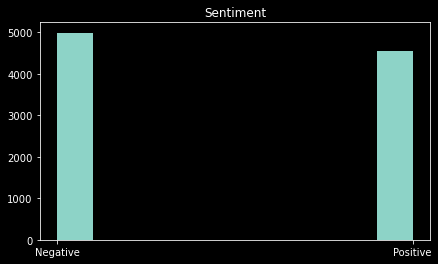

In [65]:
plt.style.use('dark_background')
fig=plt.figure(figsize=(7,4))
a = datos["Sentiment"].copy()
a[pd.isnull(a)]="Sin especificar"
plt.hist(a)
plt.title("Sentiment")

### Encoders

In [66]:
le = LabelEncoder()
le.fit(["Positive", "Negative", "Neutral"])
datos["Sentiment"] = le.transform(datos["Sentiment"])
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

### Fechas

In [67]:
datos["Date"]=pd.to_datetime(datos["Date"])
datos["year"] = datos["Date"].dt.year
datos["month"] = datos["Date"].dt.month
datos["day"] = datos["Date"].dt.day

In [68]:
datos.head()

,Date,text,Sentiment,Conteo,Moda,Max,Min,Ntags,Nmentions,Nurls,tags,mentions,newText,year,month,day
3583058,2018-08-03,@lifeoncoin,0,11,@lifeoncoin,11,11,0,0,0,[],[lifeoncoin],,2018,8,3
8839737,2019-07-03,La ‘revolución’ del,2,19,La,12,2,0,0,0,[],[],la ‘revolución’ del,2019,7,3
558264,2019-05-24,This company PAYS DAILY and in BITCOIN!\n\nBes...,2,124,This,23,2,0,1,1,[],[youtube],this company pays daily and in bitcoin! best ...,2019,5,24
14811155,2019-09-11,One Bitcoin now worth $10068.713. Market Cap $...,2,94,One,11,2,2,0,0,"[coindesk, bitcoin]",[],one bitcoin now worth $10068.713. market cap $...,2019,9,11
2376931,2018-02-06,https://www.c-span.org/video/?440770-1/jay-cla...,2,125,https://www.c-span.org/video/?440770-1/jay-cla...,109,4,0,0,1,[],[],$alts $btc $eth,2018,2,6


### Traducir

In [69]:
# for l in languages:
#     translator= Translator(to_lang='en', from_lang=l)
#     datos.loc[datos['lang']==l]['newText'] = datos.loc[datos['lang']==l]['newText'].apply(lambda x: translator.translate(x))

In [70]:
# translator= Translator(to_lang='en', from_lang='ja')
# a = datos.loc[datos['lang']=='ja']['newText'].iloc[0]
# translator.translate(a)

In [71]:
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context
# nltk.download('stopwords')

### StopWords

In [72]:
languages = ['ar',
  'ca',
  'cs',
  'de',
  'el',
  'en',
  'es',
  'fi',
  'fr',
  'hu',
  'it',
  'ja',
  'kr',
  'nl',
  'no',
  'pl',
  'pt',
  'ru',
  'sk',
  'sv',
  'tr',
  'zh']

stop_words = []
for i in languages:
    stop_words = stop_words + list(many_stop_words.get_stop_words(i))
stop_words.append('\'')
stop_words.append('`')
stop_words.append('’')
stop_words.append('‘')

In [73]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/diego/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [74]:
ps = PorterStemmer()
corpus = []
stemmed_phrase = []
for i in datos["newText"]:
    new = emoji.get_emoji_regexp().sub(" ", i)
    new = new.lower()
    new = nltk.word_tokenize(new)
    stemmed = [ps.stem(i) for i in new if i not in stop_words]
    stemmed = ' '.join(stemmed)
    corpus.append(new)
    stemmed_phrase.append(stemmed)
    
datos["Tokens"] = corpus
datos["Stemmed"] = stemmed_phrase


In [75]:
datos["TagsText"] = datos["tags"].apply(lambda x: ' '.join(map(str, x)))
datos["MentionsText"] = datos["mentions"].apply(lambda x: ' '.join(map(str, x)))

In [76]:
datos.head(10)

,Date,text,Sentiment,Conteo,Moda,Max,Min,Ntags,Nmentions,Nurls,tags,mentions,newText,year,month,day,Tokens,Stemmed,TagsText,MentionsText
3583058,2018-08-03,@lifeoncoin,0,11,@lifeoncoin,11,11,0,0,0,[],[lifeoncoin],,2018,8,3,[],,,lifeoncoin
8839737,2019-07-03,La ‘revolución’ del,2,19,La,12,2,0,0,0,[],[],la ‘revolución’ del,2019,7,3,"[la, ‘, revolución, ’, del]",revolución,,
558264,2019-05-24,This company PAYS DAILY and in BITCOIN!\n\nBes...,2,124,This,23,2,0,1,1,[],[youtube],this company pays daily and in bitcoin! best ...,2019,5,24,"[this, company, pays, daily, and, in, bitcoin,...",compani pay daili bitcoin ! onlin earn opportu...,,youtube
14811155,2019-09-11,One Bitcoin now worth $10068.713. Market Cap $...,2,94,One,11,2,2,0,0,"[coindesk, bitcoin]",[],one bitcoin now worth $10068.713. market cap $...,2019,9,11,"[one, bitcoin, now, worth, $, 10068.713, ., ma...",bitcoin worth $ 10068.713 . market cap $ 180.5...,coindesk bitcoin,
2376931,2018-02-06,https://www.c-span.org/video/?440770-1/jay-cla...,2,125,https://www.c-span.org/video/?440770-1/jay-cla...,109,4,0,0,1,[],[],$alts $btc $eth,2018,2,6,"[$, alts, $, btc, $, eth]",$ alt $ btc $ eth,,
14728223,2019-09-09,Get Free Cryptocurrency at EarnCrypto https://...,0,102,Get,23,2,4,0,1,"[ada, mtl, waves, btc]",[],get free cryptocurrency at earncrypto $bt...,2019,9,9,"[get, free, cryptocurrency, at, earncrypto, $,...",free cryptocurr earncrypto $ btc $ xrp $ ltc $...,ada mtl waves btc,
8929042,2019-07-04,"@paul_btc Baby steps, if part of rent/food bec...",0,188,part,12,1,0,0,0,[],[paul_btc],"baby steps, if part of rent/food becomes deno...",2019,7,4,"[baby, steps, ,, if, part, of, rent/food, beco...","babi step , rent/food denomin bitcoin paycheck...",,paul_btc
16554482,2019-10-08,#crypto price changes last hour\n\n🚀\n$PMA +50...,0,145,#crypto,17,4,2,0,0,"[crypto, bitcoin, cryptocurrency]",[],price changes last hour 🚀 $pma +50.28% $npxs...,2019,10,8,"[price, changes, last, hour, $, pma, +50.28, %...",price hour $ pma +50.28 % $ npx +50.28 % $ btt...,crypto bitcoin cryptocurrency,
8902043,2019-07-04,La ‘revolución’ del,0,19,La,12,2,0,0,0,[],[],la ‘revolución’ del,2019,7,4,"[la, ‘, revolución, ’, del]",revolución,,
5876841,2019-05-30,Yeni yatırımcılar için alım fırsatı demek isti...,0,124,Yeni,23,4,2,0,1,"[btc, eth]",[],yeni yatırımcılar için alım fırsatı demek isti...,2019,5,30,"[yeni, yatırımcılar, için, alım, fırsatı, deme...",yeni yatırımcılar alım fırsatı demek istiyorum...,btc eth,


In [77]:
stemmed_data = datos["Stemmed"] 

In [78]:
stemmed_text_vectorizer = TfidfVectorizer(binary=True)
stemmed_data = stemmed_text_vectorizer.fit_transform(datos["Stemmed"] )
print(stemmed_data.shape)
df_stemmed = pd.DataFrame(stemmed_data.toarray())

(9536, 19169)


In [79]:
tags_text_vectorizer = CountVectorizer(binary=True)
tags_data = tags_text_vectorizer.fit_transform(datos["TagsText"])
print(tags_data.shape)
df_tags = pd.DataFrame(tags_data.toarray())

(9536, 4426)


In [80]:
mentions_text_vectorizer = CountVectorizer(binary=True)
mentions_data = tags_text_vectorizer.fit_transform(datos["MentionsText"])
print(mentions_data.shape)
df_mentions = pd.DataFrame(mentions_data.toarray())

(9536, 2636)


In [81]:
# Se concatenan todas las columnas con datos numéricos
X = pd.concat([datos[["Conteo", "Max", "Min", "Ntags", "Nmentions", "Nurls", "year", "month", "day"]].reset_index(drop=True), df_tags, df_mentions], axis=1)
Y = datos["Sentiment"].reset_index(drop=True)

In [82]:
X

,Conteo,Max,Min,Ntags,Nmentions,Nurls,year,month,day,0,...,2626,2627,2628,2629,2630,2631,2632,2633,2634,2635
0,11,11,11,0,0,0,2018,8,3,0,...,0,0,0,0,0,0,0,0,0,0
1,19,12,2,0,0,0,2019,7,3,0,...,0,0,0,0,0,0,0,0,0,0
2,124,23,2,0,1,1,2019,5,24,0,...,0,0,0,0,0,0,0,0,0,0
3,94,11,2,2,0,0,2019,9,11,0,...,0,0,0,0,0,0,0,0,0,0
4,125,109,4,0,0,1,2018,2,6,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9531,109,8,1,6,0,0,2019,9,16,0,...,0,0,0,0,0,0,0,0,0,0
9532,85,85,85,0,0,0,2019,11,7,0,...,0,0,0,0,0,0,0,0,0,0
9533,99,13,2,0,0,0,2019,1,23,0,...,0,0,0,0,0,0,0,0,0,0
9534,67,16,0,2,0,0,2019,8,26,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
Y

0       0
1       2
2       2
3       2
4       2
       ..
9531    0
9532    0
9533    0
9534    2
9535    2
Name: Sentiment, Length: 9536, dtype: int64

## Construcción de modelos

## Arbol de decisión

In [114]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [115]:
arbol = DecisionTreeClassifier(random_state=0)

In [116]:
arbol = arbol.fit(X_train, Y_train)

In [117]:
y_pred = arbol.predict(X_test)

In [118]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.94
Recall: 0.9444250262146103
Precisión: 0.9444380083755479
Puntuación F1: 0.9444286296437533


In [119]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,20],'min_samples_split':[2, 3, 4, 5]}

In [120]:
# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = DecisionTreeClassifier(random_state=0)

In [121]:
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 20],
                         'min_samples_split': [2, 3, 4, 5]})

In [122]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
mejor_modelo.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 3}

In [123]:
y_pred = mejor_modelo.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.96
Recall: 0.9587556798322265
Precisión: 0.958888867783752
Puntuación F1: 0.9587655553891136


In [124]:
arbol_final = mejor_modelo.best_estimator_

In [125]:
 # Usamos la lbreria joblib
filename = 'arbol.joblib'
# Se guarda
dump(arbol_final, filename)

['arbol.joblib']

In [126]:
importancia= mejor_modelo.best_estimator_.feature_importances_
importancia

array([0.04204054, 0.01499739, 0.00883975, ..., 0.        , 0.        ,
       0.        ])

In [127]:
# Se obtiene la importancia de cada uno de los atributos para el resultado del mejor modelo
importancia_atributo = pd.DataFrame(data={"Atributo": X_train.columns,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo.head()

,Atributo,Importancia
0,day,0.560510
1,month,0.238041
2,year,0.112309
3,Conteo,0.042041
4,Max,0.014997


In [128]:
importancia_atributo.head(15)

,Atributo,Importancia
0,day,0.560510
1,month,0.238041
2,year,0.112309
3,Conteo,0.042041
4,Max,0.014997
5,Min,0.008840
6,Nurls,0.003269
7,Ntags,0.003038
8,3346,0.001814
9,1987,0.001753


## KNN

In [97]:
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)

In [98]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.57
Recall: 0.5700803914715135
Precisión: 0.569631474471598
Puntuación F1: 0.5697211284659609


In [99]:
# Búsqueda de hiper parámetros en KNN
# Lista de Hiperparámetros a afinar
n_neighbors = list(range(1,20))
n_odd_neighbors = list(filter(lambda x: (x % 2 != 0), n_neighbors))
p=[1,2] #Función de distancia 1: manhattan, 2: euclidean, otro valor: minkowski

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()

In [100]:
#Usamos GridSearch
mejor_modelo_knn = GridSearchCV(knn_2, hyperparameters, cv=10)

#Fit the model
mejor_modelo_knn.fit(X_train, Y_train)

# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
print('Best p:', mejor_modelo_knn.best_estimator_.get_params()['p'])
print('Best n_neighbors:', mejor_modelo_knn.best_estimator_.get_params()['n_neighbors'])
# Obtener el mejor modelo.
neigh_final = mejor_modelo_knn.best_estimator_

Best p: 1
Best n_neighbors: 1


In [101]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
neigh_final

KNeighborsClassifier(n_neighbors=1, p=1)

In [102]:
#Estadisticas con el conjunto de prueba
y_pred = neigh_final.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.59
Recall: 0.5927997203774904
Precisión: 0.5930778651194749
Puntuación F1: 0.5929005049211218


## Random Forest

In [103]:
forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=2)
forest = forest.fit(X_train, Y_train)

In [104]:
y_pred = forest.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.52
Recall: 0.5193988116043341
Precisión: 0.2697751254959946
Puntuación F1: 0.3551077221274628


In [105]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'n_estimators':[50, 100, 200],'criterion':['gini', 'entropy'],'max_depth':[None,4,10,20],'min_samples_split':[4, 10, 20]}

In [106]:
forest = RandomForestClassifier()
# Se comprueban los mejores hiperparametros
mejor_modelo = GridSearchCV(forest, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 4, 10, 20],
                         'min_samples_split': [4, 10, 20],
                         'n_estimators': [50, 100, 200]})

In [107]:
mejor_modelo.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 10,
 'n_estimators': 100}

In [108]:
y_pred = mejor_modelo.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.71
Recall: 0.7102411744145404
Precisión: 0.710580948792256
Puntuación F1: 0.7094106161730892


In [110]:
 # Usamos la lbreria joblib
filename = 'rf.joblib'
# Se guarda
dump(mejor_modelo.best_estimator_, filename)

['rf.joblib']

In [111]:
 # Usamos la lbreria joblib
filename = 'knn.joblib'
# Se guarda
dump(neigh_final, filename)

['knn.joblib']